# PLSC 597 - Homework 3
### Maya Dalton (11/13/23)

Please find my Jupyter Notebook file and data file for this assignment [here.](https://github.com/mad6821/PLSC-597---Machine-Learning)

Nemeth, Stephen. (2014). The Effect of Competition on Terrorist Group Operations. The Journal of Conflict Resolution, 58(2), 336–362. http://www.jstor.org/stable/24545641

In [264]:
# Importing libraries, storing as shorthand
import numpy as np       
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix

In [265]:
df = pd.read_stata('FINALDATASET.dta') # Load in data
df_c = df[['attack2', 'lagcompetition2', 'lagfactor', 'lagcompfactint2', 'laganocyn', 'lagdemyn',
        'laggdppc', 'lagrpc2', 'lagcivwar', 'laglogpop']] # Select needed variables
df_c = df_c.dropna() # Drop NAs

df_c = df_c.rename(columns={'attack2': 'terrorism', 'lagcompetition2': 'Competition', 'lagfactor':'Acceptability of violence',
                           'lagcompfactint2':'Competition x Acceptability', 'laganocyn':'Anocracy', 'lagdemyn':'Democracy',
                           'laggdppc':'GDP', 'lagrpc2':'RPC', 'lagcivwar':'Civil War', 'laglogpop':'Log Population'})

print(df_c.head())

    terrorism  Competition  Acceptability of violence  \
11        8.0          1.0                  -0.952738   
12        0.0          1.0                  -0.952738   
13        0.0          1.0                  -0.952738   
14        0.0          1.0                  -0.952738   
15        1.0          1.0                  -0.952738   

    Competition x Acceptability  Anocracy  Democracy          GDP       RPC  \
11                    -0.952738       0.0        1.0  4878.370117  0.622221   
12                    -0.952738       0.0        1.0  4878.370117  0.622221   
13                    -0.952738       0.0        1.0  4878.370117  0.622221   
14                    -0.952738       0.0        1.0  4878.370117  0.622221   
15                    -0.952738       0.0        1.0  4878.370117  0.622221   

    Civil War  Log Population  
11        0.0       12.255392  
12        0.0       12.255392  
13        0.0       12.255392  
14        0.0       12.255392  
15        0.0       12

## Question 1
Nemeth (2014) examines the relationship between competition among terrorist groups and the level of violence used by opposition (also called "outbidding". He argues that competition actually creates incentives to use *less* violence, when government policy and social acceptability of violence are not present. Nemeth uses a data set of domestic terrorism created from the Global Terrorism Database (GTD) for the years 1970 to 1997. The dependent variable is a count variable of yearly domestic terror attacks committed by each organization. For the independent variable, he uses the Herfindahl-Hirschman Index (HHI), classifying four individual "markets" of ideology: nationalist, religious, left-wing, or right-wing. He also controls for regime type, GDP, participation in civil war, and population. Nemeth employs an event count model (Negative Binomial) due to the dependent and overdispersed nature of the dependent variable. He finds that competition has a negative effect on terrorism attacks. I have replicated the main results of this model below. 

In [278]:
X = df_c.drop(['terrorism'], axis=1) # Drop DV 
y = df_c[['terrorism']]

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)

# Fit the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Print the summary of the regression
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              terrorism   No. Observations:                 3031
Model:                            GLM   Df Residuals:                     3021
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8264.7
Date:                Fri, 10 Nov 2023   Deviance:                       10039.
Time:                        15:30:44   Pearson chi2:                 3.40e+04
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Question 2
Here, I apply PCA with 5 compontents to the independent variables. As shown in the first plot, the first principal component accounts for 40% of the variance in the dataset. The second principal component explains about 75% of the variance. I will continue by analyzing these first two components, and how the independent variables map onto them. 

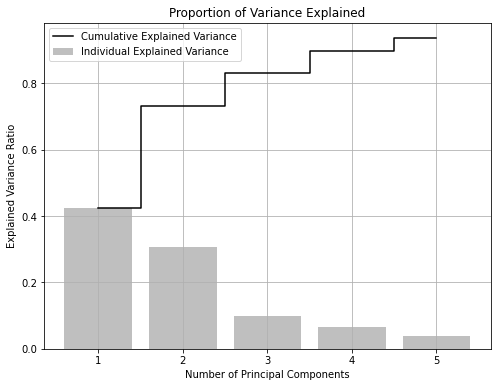

In [242]:
X_sc = MinMaxScaler(feature_range=(-1,1)).fit_transform(df_c.iloc[:,1:])

pc = PCA(n_components=5).fit(X_sc)
cumulative_variance_ratio = np.cumsum(pc.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.step(range(1, len(pc.explained_variance_ratio_) + 1), cumulative_variance_ratio, where='mid', color='black', label='Cumulative Explained Variance')
plt.bar(range(1, len(pc.explained_variance_ratio_) + 1), pc.explained_variance_ratio_, color='gray', alpha=0.5, label='Individual Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Proportion of Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

After conducting PCA with two components, I split the data into 70% training and 30% test sets using the results of PCA. The second figure examines how the training data maps onto the first and second principal compontents. Interestingly, there are 5 groups of terrorist organizations clustered around loadings onto PC1 and PC2. This clustering could be recovering the ideological "markets" Nemeth discusses, as well as different terrorist organizations in regime types or civil war. 

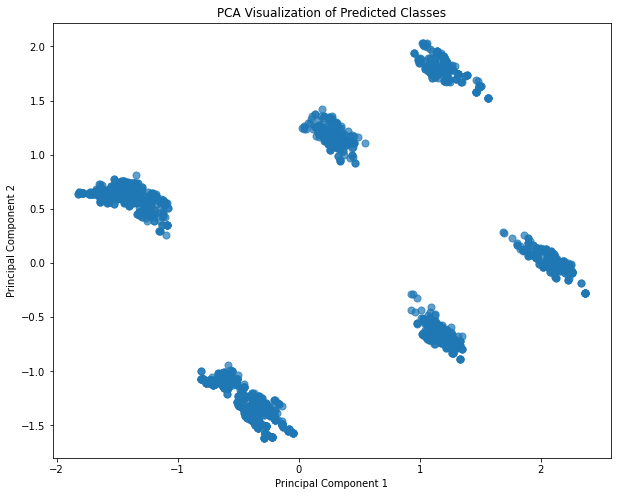

In [271]:
pc = PCA(n_components=2).fit(X_sc)
X_pca = pc.transform(X_sc)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
y_train = np.ravel(y_train)

plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], cmap='rainbow', s=50, alpha=0.7, label='Predicted Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Predicted Classes')

plt.show()

Finally, I examine how much each independent variable contributes to a given principal component. The figures below shows the loadings onto PC1 and PC2 by each feature. Democracy, GDP, and population load negatively onto the first dimension, and acceptability of violence, anocracy, and civil war load positively. This dimension likely recovers some latent measure of acceptability of violence, rather than competition. 

For the second dimension, anocracy loads positively, and the other features load negatively. The civil war variable negatively maps onto this dimension stronger than the others, indicating this dimension is measuring something pertaining to persistence of violence and engagement in interstate war, rather than competition.  

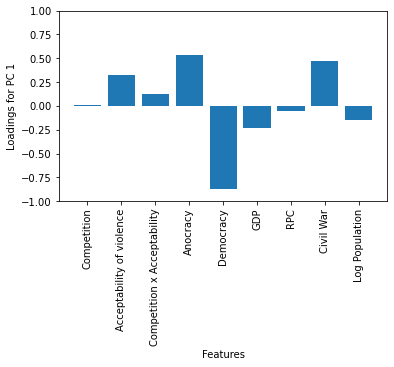

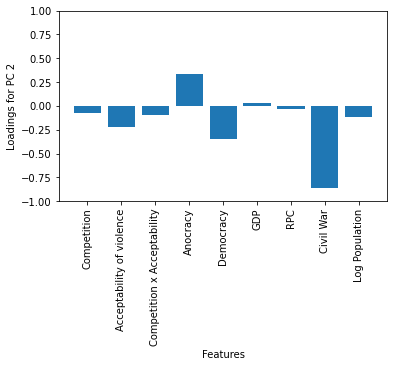

In [218]:
loadings_pc1 = pc.components_[0] * np.sqrt(pc.explained_variance_[0])

labels = ['Competition', 'Acceptability of violence', 'Competition x Acceptability', 'Anocracy', 'Democracy',
         'GDP', 'RPC', 'Civil War', 'Log Population']
plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)  
plt.bar(range(len(loadings_pc1)), loadings_pc1, align='center')
plt.xlabel('Features')
plt.ylabel('Loadings for PC 1')
plt.xticks(np.arange(len(loadings_pc1)), labels, rotation=90)
plt.ylim(-1, 1)
plt.tight_layout()

plt.show()

loadings_pc2 = pc.components_[1] * np.sqrt(pc.explained_variance_[1])
labels = ['Competition', 'Acceptability of violence', 'Competition x Acceptability', 'Anocracy', 'Democracy',
         'GDP', 'RPC', 'Civil War', 'Log Population']
plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)  
plt.bar(range(len(loadings_pc2)), loadings_pc2, align='center')
plt.xlabel('Features')
plt.ylabel('Loadings for PC 2')
plt.xticks(np.arange(len(loadings_pc2)), labels, rotation=90)
plt.ylim(-1, 1)
plt.tight_layout()

plt.show()

## Question 3
The PCA model has a significantly better accuracy score than the count model, at 61%. The count model has an accuracy score of 10.3%. Because the PCA model recovers dimensions likely measuring regime type, acceptability of violence, and engagement in conflict, it would do better at predicting terrorist groups that engage in violence. The count model, while controlling for these factors, finds that some of these variables are not statistically significant, and do not influence terrorist organizations' engagement in violence.  

In [289]:
## Original Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.ravel(y_train)

y_prob_lr = model.predict(sm.add_constant(X_test))
y_pred_lr = (y_prob_lr > 0.5).astype(int)

# Manually compute accuracy
accuracy = accuracy_score(y_test, y_pred_lr)

print(f"County Model Accuracy:, {accuracy:.5f}")

# PCA Model
svc = SVC()
svc.fit(X_train, y_train)
y_pred_pca = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_pca)
print(f"PCA Accuracy: {accuracy:.5f}")

County Model Accuracy:, 0.10379
PCA Accuracy: 0.60956
